<a href="https://colab.research.google.com/github/ahmedabdelhameed/TensorFlow/blob/main/VAE_Autoencoder_MNIST_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Variational convolutional autoecncoder implementation tested on MNIST dataset**

In [1]:
import numpy as np
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, BatchNormalization, Flatten, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt

In [2]:
#Downloading the dataset
(x_train_orig, y_train), (x_test_orig, y_test) = mnist.load_data()
x_train = x_train_orig.astype('float32') / 255.
x_test = x_test_orig.astype('float32') / 255.

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)) 
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
img_size = 28
num_channels = 1

In [4]:
# Building the encoder
x = Input(shape=(img_size, img_size, num_channels), name="encoder_input")
encoder_conv_layer1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
                             strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

In [5]:
shape_before_flatten = K.int_shape(encoder_activ_layer5)[1:]
#shape_before_flatten = K.int_shape(encoder_activ_layer5) returns (None, 7, 7, 64)
encoder_flatten = Flatten()(encoder_activ_layer5)

In [6]:
latent_space_dim = 2

encoder_mu = Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

In [7]:
# Defining sampling function
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.0)
  return z_mean + K.exp(z_log_var / 2) * epsilon

# epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
# def sampling(mu_log_variance):
#     mu, log_variance = mu_log_variance
#     epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
#     random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
#     return random_sample
encoder_output = Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])
# z = Lambda(sampling,  name="encoder_output")([encoder_mu, encoder_log_variance])
# encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

encoder = Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 28, 28, 1)    10          encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 28, 28, 1)    4           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 28, 28, 1)    0           encoder_norm_1[0][0]             
______________________________________________________________________________________

In [8]:
# Defining the decoder using functional API
decoder_input = Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

# decoder_conv_tran_layer4 = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
# decoder_output = LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder_conv_tran_layer4 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, activation='sigmoid', name="decoder_output")(decoder_activ_layer3)
decoder_output = decoder_conv_tran_layer4 

decoder = Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 7, 7, 64)          256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 14, 14, 64)      

In [9]:
# Defining the variational autoencoder 
vae_input = Input(shape=(img_size, img_size, num_channels), name="VAE_input")

vae_encoder_output = encoder(vae_input)

vae_decoder_output = decoder(vae_encoder_output)

vae = Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 2)                 106130    
_________________________________________________________________
decoder_model (Functional)   (None, 28, 28, 1)         121537    
Total params: 227,667
Trainable params: 226,833
Non-trainable params: 834
_________________________________________________________________


In [10]:
# Defining the loss function
def loss_func(z_mean=encoder_mu, z_log_var=encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss =  K.mean(K.square(y_true- y_predict), axis=[1, 2, 3])
        #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_predict))
        #reconstruction_loss = binary_crossentropy(y_true, y_predict)
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_log_var):
        kl_loss = -0.5 * K.sum(1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        #kl_loss = -0.5 * K.sum(1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss
    # xent_loss = original_dim * tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
    # kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    # vae_loss = tf.mean(xent_loss + kl_loss)
    return vae_loss

In [11]:
vae.compile(optimizer=Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [12]:
vae.fit(x_train, x_train, epochs=20, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 27s 5ms/step - loss: 63.7072 - val_loss: 50.2140
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 49.3364 - val_loss: 47.2532
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 46.9512 - val_loss: 45.9579
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 45.8523 - val_loss: 44.6388
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 44.8998 - val_loss: 44.1723
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 44.3819 - val_loss: 44.1472
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 43.8121 - val_loss: 44.2143
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 43.5690 - val_loss: 43.1403
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 43.2999 - val_loss: 42.9054
Epoch 10/20
1875/1875 [==============================] - 9s 5ms

In [ ]:
encoder.save("VAE_encoder.h5") 
decoder.save("VAE_decoder.h5") 
vae.save("VAE.h5")

In [ ]:
encoder = load_model("VAE_encoder.h5", compile=False)
decoder = load_model("VAE_decoder.h5", compile=False)

In [13]:
encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

decoded_images = np.reshape(decoded_data, newshape=(decoded_data.shape[0], 28, 28))

In [14]:
decoded_images.shape

(10000, 28, 28)

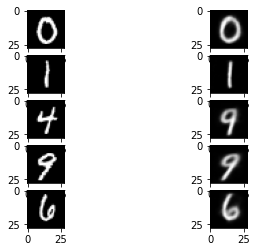

In [15]:
num_images_to_show = 5
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*2 + 1
    rand_ind = np.random.randint(low=0, high=x_test.shape[0])
    plt.subplot(num_images_to_show, 2, plot_ind)
    plt.imshow(x_test_orig[rand_ind, :, :], cmap="gray")
    plt.subplot(num_images_to_show, 2, plot_ind+1)
    plt.imshow(decoded_images[rand_ind, :, :], cmap="gray")

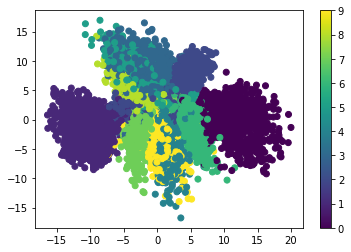

In [16]:
# display a 2D plot of the 10 classes in the latent space
x_test_encoded = encoder.predict(x_test)
plt.figure()
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()

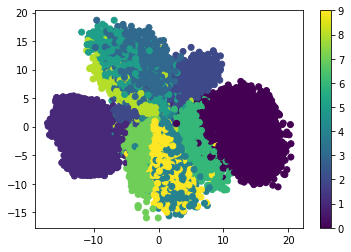

In [17]:
# display a 2D plot of the 10 classes in the latent space
x_train_encoded = encoder.predict(x_train)
plt.figure()
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train)
plt.colorbar()